In [90]:
import json
import overpy

import pandas as pd
import geopandas as gpd
import numpy as np

from shapely.geometry import Point, GeometryCollection, shape, MultiPoint
from shapely.affinity import affine_transform
from scipy.ndimage import distance_transform_bf, distance_transform_edt
from matplotlib import pyplot as plt
from matplotlib import colors, patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib_scalebar.scalebar import ScaleBar

from PIL import Image, ImageDraw

In [103]:
# (53.344249, -6.268799, 53.346190, -6.261815)
# area[alt_name="Dublin City"] -> .a;



overpass = overpy.Overpass()
result = overpass.query("""
area[name="County Dublin"] -> .a;
(
node(area.a)["amenity"="pub"];
way(area.a)["amenity"="pub"];
);
out meta center;
""")

# 53.346190, -6.268799
# 53.344249, -6.261815

Plotting 682 pubs


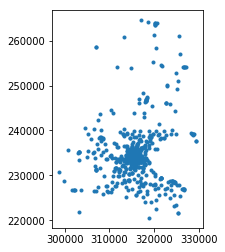

In [104]:
pubs_from_nodes = [[n.id, n.tags.get('name', None), Point(n.lon, n.lat)]
        for n in result.nodes]

pubs_from_ways = [[w.id, w.tags.get('name', None), Point(w.center_lon, w.center_lat)]
                  for w in result.ways 
                  if w.center_lon and w.center_lat]

pubs = pd.DataFrame(pubs_from_nodes + pubs_from_ways, columns=['id', 'name', 'coord'])
pubs.set_index('id')

pubs = gpd.GeoDataFrame(pubs, geometry='coord')
pubs.crs = {'init': 'epsg:4326'}
pubs = pubs.to_crs(epsg=29902)
print(f"Plotting {len(pubs)} pubs")
pubs.plot(marker='.');

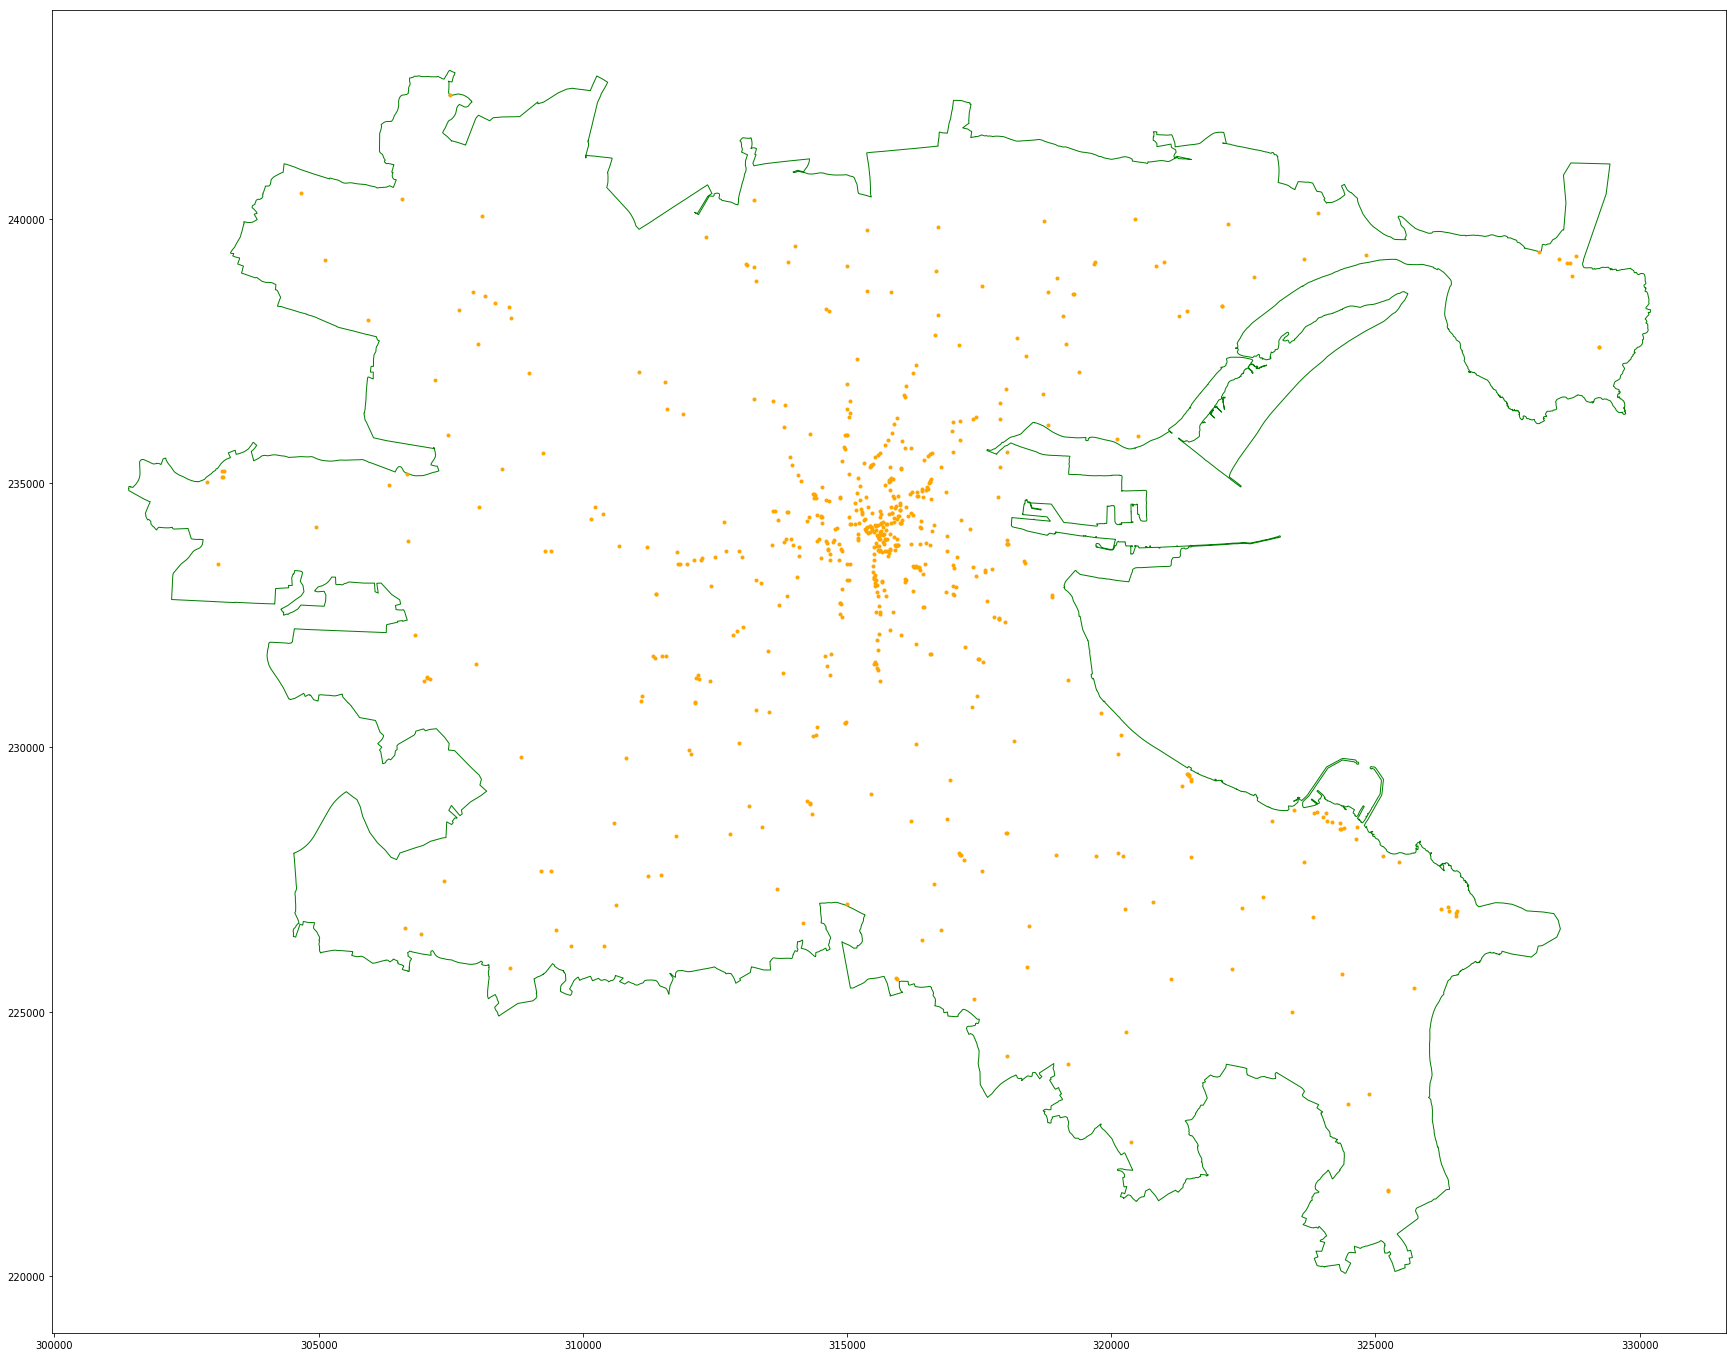

In [105]:
settlements = gpd.read_file("/Users/fester/Downloads/Census2011_Settlements/Census2011_Settlements.shp")
region = settlements[settlements.SETTL_NAME.str.contains("Dublin")]
region = region.to_crs(epsg=29902)

pubs = pubs[pubs.intersects(region.unary_union)]
base = region.plot(figsize=(30, 30), color='white', edgecolor='green')
pubs.plot(ax=base, marker='.', color='orange');

In [106]:
def poly_to_stencil(polygon, shape, fill=1):
    vertices = list(zip(*polygon.exterior.coords.xy))
    h, w = shape
    raster = Image.new('1', (w, h), 0)
    draw = ImageDraw.Draw(raster)
    draw.polygon(vertices, fill)
    return np.asarray(raster)


def scale_to_pixel_space(meters_per_pixel, min_x, min_y, max_x, max_y):
    dx = max_x - min_x
    dy = max_y - min_y
    
    aspect_ratio = dx/dy
    image_buffer_width = int(dx/meters_per_pixel)
    image_buffer_height = int(image_buffer_width/aspect_ratio)
    
    transformation_matrix = [image_buffer_width/dx, 0, 0, image_buffer_height/dy, 
                             -image_buffer_width*min_x/dx, -image_buffer_height*min_y/dy]
    
    canvas = np.ones((image_buffer_height, image_buffer_width), dtype=np.float)
    
    def tr(sh):
        return affine_transform(shape(sh), transformation_matrix)
    
    return {'affine_transform': tr,
            'canvas': canvas}

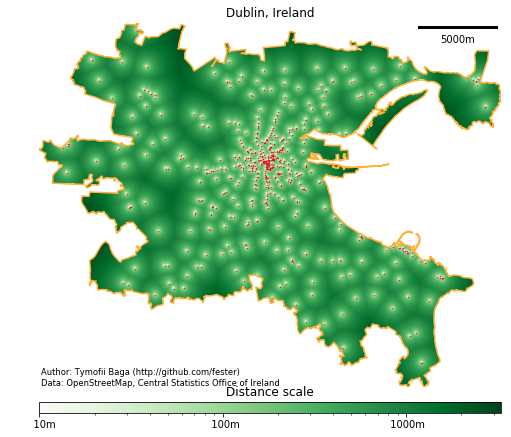

In [116]:
meters_per_pixel = 10

pixel_space = scale_to_pixel_space(meters_per_pixel, *region.total_bounds)

a_shape = shape(region.unary_union)

at = pixel_space['affine_transform']
canvas = pixel_space['canvas']

scaled_shape = at(a_shape)
scaled_points = pubs.coord.map(at)

canvas[np.round(scaled_points.y).astype(np.int), np.round(scaled_points.x).astype(np.int)] = 0
area_stencil = poly_to_stencil(scaled_shape, canvas.shape)

distance_map = distance_transform_edt(canvas)*meters_per_pixel
distance_map[area_stencil==False] = 0

fig, ax1 = plt.subplots(figsize=(8.27, 11.69))

ax1.axis('off')
ax1.set_title("Dublin, Ireland")

plot = ax1.imshow(distance_map, cmap='Greens', norm=colors.LogNorm(), origin='lower')

ax1.scatter(np.trunc(scaled_points.x), np.trunc(scaled_points.y), marker='o', s=0.25, c='#db1818')

patch = patches.Polygon(list(zip(*scaled_shape.exterior.coords.xy)), 
                        fill=False, color='#ffb03b', linewidth=1.5)
ax1.add_patch(patch)
plot.set_clip_path(patch)

scale_bar = ScaleBar(meters_per_pixel, units='m', label_formatter=lambda v, u: f'{v*1000}m')
ax1.add_artist(scale_bar)

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="3%", pad=0.2, pack_start=True)
cax.set_title('Distance scale')
fig.add_axes(cax)
fig.colorbar(plot, cax=cax, orientation="horizontal", format='%5.fm')
ax1.text(10, 13, "Author: Tymofii Baga (http://github.com/fester)\nData: OpenStreetMap, Central Statistics Office of Ireland",
            fontsize='small')

fig.savefig("distmap.ps", format='ps',  orientation='landscape', bbox_inches='tight', dpi=300)

